RNN with pytorch
================



## Notebook Settings



In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

%run ../notebooks/setup.py
%matplotlib inline
%config InlineBackend.figure_format = 'png'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Python exe
/home/leon/mambaforge/envs/torch/bin/python

## Imports



In [1]:
import sys
sys.path.insert(0, '../')

import torch
import pandas as pd
from time import perf_counter  

from src.network import Network
from src.plot_utils import plot_con
from src.decode import decode_bump

## Helpers



### Random



In [1]:
def convert_seconds(seconds):
    h = seconds // 3600
    m = (seconds % 3600) // 60
    s = seconds % 60
    return h, m, s

In [1]:
def get_theta(a, b, GM=0, IF_NORM=0):

    if GM:          
        b = b - np.dot(b, a) / np.dot(a, a) * a

    if IF_NORM:
        u = a / np.linalg.norm(a)
        v = b / np.linalg.norm(b)
    else:
        u=a
        v=b

    return np.arctan2(v, u)

In [1]:
def normalize(v):
    return v / np.linalg.norm(v)

def project(x, u):
    return x * u
# return np.dot(x, u) * u

def sort_by_angle(x, u, v):
    u_hat = normalize(u)
    v_hat = normalize(v)

    x_proj_u = project(x, u_hat)
    x_proj_v = project(x, v_hat)
    # x_proj = x_proj_u + x_proj_v
    theta = np.arctan2(x_proj_v, x_proj_u) + np.pi

    # cos_theta = np.dot(x_proj, u_hat) / np.linalg.norm(x_proj) * u_hat
    # sin_theta = np.dot(x_proj, v_hat) / np.linalg.norm(x_proj) * v_hat
    # theta = np.arctan2(sin_theta, cos_theta)

    # Pair up each element of x with the corresponding angle
    # x_angle_pairs = list(zip(x, theta))

    # Sort based on the angle
    # x_angle_pairs.sort(key=lambda pair: pair[1])

    # Extract the sorted elements
    # sorted_x = [pair[0] for pair in x_angle_pairs]

    return theta

### Data



In [1]:
def get_rates_ini_phi(name, ini_list, phi_list):
  rates_list = []
  for ini in ini_list:
    for phi in phi_list:
      rates = np.load(REPO_ROOT + '/data/simul/%s_ini_%d_phi_%d.npy' % (name, ini, phi))
      rates_list.append(rates)

  rates_list = np.array(rates_list).reshape(len(ini_list), len(phi_list), rates.shape[0], rates.shape[1])
  print(rates_list.shape)
  return rates_list

In [1]:
def get_df_ini_phi(rates):
    n_trials, n_phi, n_times, n_neurons = rates.shape

    # Create indices
    trials_ind, phi_ind, times_ind, neurons_ind = np.indices((n_trials, n_phi, n_times, n_neurons))

    # Construct DataFrame
    df = pd.DataFrame({
        'trial': trials_ind.flatten(),
        'phi': phi_ind.flatten(),
        'neuron': neurons_ind.flatten(),
        'time': times_ind.flatten(),
        'rates': rates.flatten()
    })

    return df

In [1]:
def load_data_ini_phi(name, ini_list, phi_list):
    rates = get_rates_ini_phi(name, ini_list, phi_list)
    df = get_df_ini_phi(rates)
    return df

In [1]:
def get_code_ini_phi(df):
    df_code = df.groupby(['time', 'trial', 'phi'] )['rates'].apply(decode_bump).reset_index()
    df_code[['m0', 'm1', 'phase']] = pd.DataFrame(df_code['rates'].tolist(), index=df_code.index)
    df_code = df_code.drop(columns=['rates'])

    end_point = df_code[df_code.time==df_code.time.iloc[-1]]
    end_point = end_point.drop(columns=['time'])
    print(end_point.head())  
    return df_code, end_point

In [1]:
def get_precision(x):
    return x - circmean(x)

### Simul



In [1]:
import subprocess

def gpu_memory_usage_percentage():
    total_mem_str = subprocess.check_output(["nvidia-smi", "--query-gpu=memory.total", "--format=csv,nounits,noheader"])
    used_mem_str = subprocess.check_output(["nvidia-smi", "--query-gpu=memory.used", "--format=csv,nounits,noheader"])

    total_mem_list = map(float, total_mem_str.decode('utf-8').strip().split('\n'))
    used_mem_list = map(float, used_mem_str.decode('utf-8').strip().split('\n'))

    mem_percentage_list = [(used_mem / total_mem) * 100.0 for total_mem, used_mem in zip(total_mem_list, used_mem_list)]

    return np.array(mem_percentage_list)

memory_percentages = gpu_memory_usage_percentage()

# The memory usage for each GPU is indexed from 0
for index, percentage in enumerate(memory_percentages):
    print(f'GPU {index} Memory Usage: {percentage:.2f}%')

GPU 0 Memory Usage: 0.07%
GPU 1 Memory Usage: 0.07%

In [1]:
from time import sleep

def check_gpu(device):
    memory_percentages = gpu_memory_usage_percentage()
    if device == 'cuda:0':
        if memory_percentages[0] > 75:
            while memory_percentages[1] > 75:
                memory_percentages = gpu_memory_usage_percentage()
                sleep(10)
            else:
                device='cuda:1'
    else:
        if memory_percentages[1] > 75:
            while memory_percentages[0] > 75:
                memory_percentages = gpu_memory_usage_percentage()
                sleep(10)
            else:
                device='cuda:0'

    return device

In [1]:
device = check_gpu('cuda:0')
print(device)

cuda:0

In [1]:
# import multiprocessing
# if multiprocessing.get_start_method(allow_none=True) != 'spawn':
#   multiprocessing.set_start_method('spawn', force=True)
# from multiprocessing import Process

def run_ini_phi(conf, name, ini_list, phi_list):
    LOAD_MAT = 0
    SAVE_MAT = 1

    df_list = []
    for ini in ini_list:
        for phi in phi_list:

            print('##########################################')
            print("trial", ini, "phi", phi)
            print('##########################################')

            model = Network('%s.yml' % conf, '%s_ini_%d_phi_%d' % (name, ini, phi),
                            REPO_ROOT, LOAD_MAT=LOAD_MAT, SAVE_MAT=SAVE_MAT, PHI0=phi)

            model.run()
            # process = Process(target=model.run)
            # process.start()
            # process.join()
            # device = check_gpu(device)

            LOAD_MAT = 1
            SAVE_MAT = 0

## Connectivity



### Imports



In [1]:
from src.connectivity import Connectivity

### ODR



In [1]:
Cij = Connectivity(10000, 10000, 1000)('sparse', 'cosine', kappa=1.0, sigma=0, phase=0)

In [1]:
Cij = Cij.cpu().detach().numpy()
print(Cij.shape)

(10000, 10000)

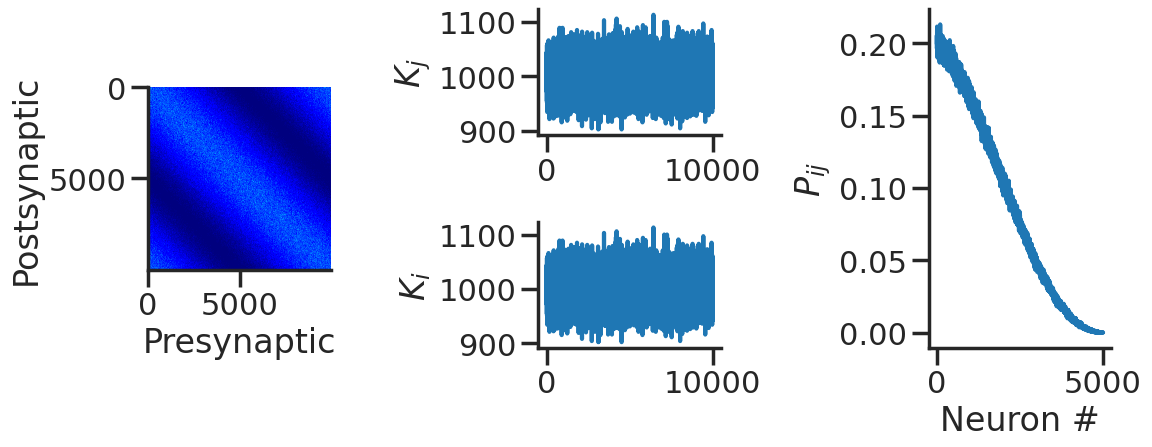

In [1]:
plt.figure(figsize=(12, 5))  # Set the figure size (width, height) in inches

ax1 = plt.subplot2grid((2, 3), (0, 0), rowspan=2)
im = ax1.imshow(Cij, cmap='jet', aspect=1)
ax1.set_xlabel("Presynaptic")
ax1.set_ylabel("Postsynaptic")

# Second column, first row
ax2 = plt.subplot2grid((2, 3), (0, 1))
Kj = np.sum(Cij, axis=0)  # sum over pres
ax2.plot(Kj)
# ax2.set_xticklabels([])
ax2.set_ylabel("$K_j$")

# # Second column, second row
ax3 = plt.subplot2grid((2, 3), (1, 1))
Ki = np.sum(Cij, axis=1)  # sum over pres
ax3.plot(Kj)
ax3.set_ylabel("$K_i$")

ax4 = plt.subplot2grid((2, 3), (0, 2), rowspan=2)
diags = []
for i in range(int(Cij.shape[0] / 2)):
    diags.append(np.trace(Cij, offset=i) / Cij.shape[0])
diags = np.array(diags)
ax4.plot(diags)
ax4.set_xlabel("Neuron #")
ax4.set_ylabel("$P_{ij}$")

plt.tight_layout()
plt.show()

### Dual Task



In [1]:
Con = Connectivity(10000, 10000, 1000)
Cij = Con('sparse', 'lr', kappa=4, lr_mean=[0, 0], lr_cov=[[1, 0], [0, 1]])

low rank probability

In [1]:
Cij = Cij.cpu().detach().numpy()
print(Cij.shape)

(1000, 1000)

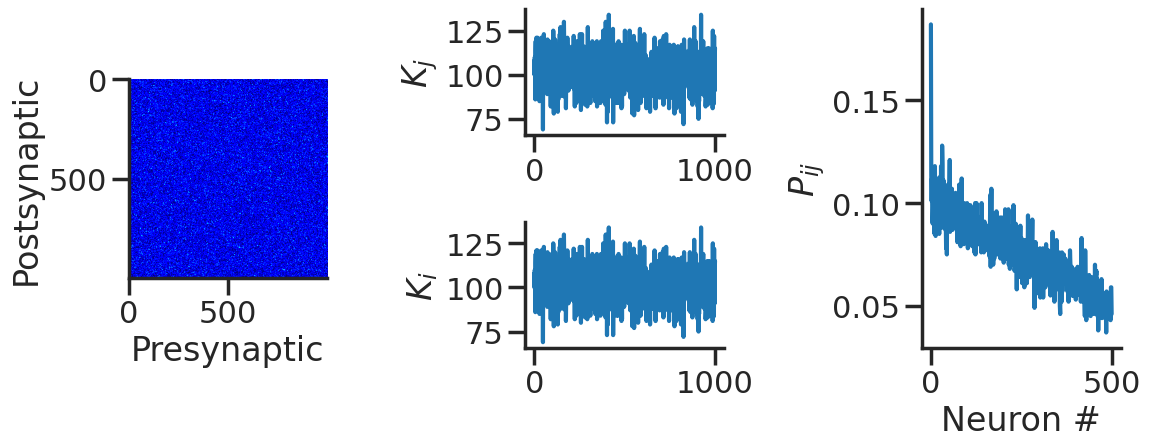

In [1]:
plt.figure(figsize=(12, 5))  # Set the figure size (width, height) in inches

ax1 = plt.subplot2grid((2, 3), (0, 0), rowspan=2)
im = ax1.imshow(Cij, cmap='jet', aspect=1)
ax1.set_xlabel("Presynaptic")
ax1.set_ylabel("Postsynaptic")

# Second column, first row
ax2 = plt.subplot2grid((2, 3), (0, 1))
Kj = np.sum(Cij, axis=0)  # sum over pres
ax2.plot(Kj)
# ax2.set_xticklabels([])
ax2.set_ylabel("$K_j$")

# # Second column, second row
ax3 = plt.subplot2grid((2, 3), (1, 1))
Ki = np.sum(Cij, axis=1)  # sum over pres
ax3.plot(Kj)
ax3.set_ylabel("$K_i$")

ax4 = plt.subplot2grid((2, 3), (0, 2), rowspan=2)
diags = []
for i in range(int(Cij.shape[0] / 2)):
    diags.append(np.trace(Cij, offset=i) / Cij.shape[0])
diags = np.array(diags)
ax4.plot(diags)
ax4.set_xlabel("Neuron #")
ax4.set_ylabel("$P_{ij}$")

plt.tight_layout()
plt.show()

In [1]:
ksi = Con.ksi.cpu().detach().numpy()
print('ksi', ksi.shape)
idx = np.arange(0, len(ksi[0]))
# print(theta.shape)
theta = get_theta(ksi[0], ksi[1], GM=0, IF_NORM=1)
theta = np.arctan2(ksi[1], ksi[0])
index_order = theta.argsort()
# print(index_order)
Cij_ordered = Cij[index_order][index_order]
print(Cij_ordered.shape)

ksi (2, 1000)
(1000, 1000)

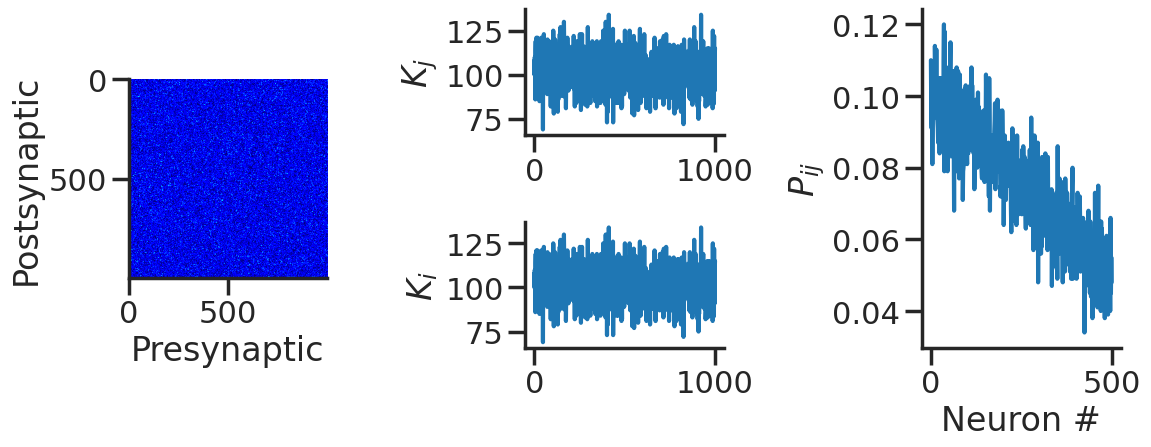

In [1]:
plt.figure(figsize=(12, 5))  # Set the figure size (width, height) in inches

ax1 = plt.subplot2grid((2, 3), (0, 0), rowspan=2)
im = ax1.imshow(Cij_ordered, cmap='jet', aspect=1)
ax1.set_xlabel("Presynaptic")
ax1.set_ylabel("Postsynaptic")

# Second column, first row
ax2 = plt.subplot2grid((2, 3), (0, 1))
Kj = np.sum(Cij_ordered, axis=0)  # sum over pres
ax2.plot(Kj)
# ax2.set_xticklabels([])
ax2.set_ylabel("$K_j$")

# # Second column, second row
ax3 = plt.subplot2grid((2, 3), (1, 1))
Ki = np.sum(Cij_ordered, axis=1)  # sum over pres
ax3.plot(Kj)
ax3.set_ylabel("$K_i$")

ax4 = plt.subplot2grid((2, 3), (0, 2), rowspan=2)
diags = []
for i in range(int(Cij_ordered.shape[0] / 2)):
    diags.append(np.trace(Cij_ordered, offset=i) / Cij_ordered.shape[0])
diags = np.array(diags)
ax4.plot(diags)
ax4.set_xlabel("Neuron #")
ax4.set_ylabel("$P_{ij}$")

plt.tight_layout()
plt.show()

### Sparse



In [1]:
REPO_ROOT = "/home/leon/models/NeuroTorch"
model = Network('config_EI.yml', 'test', REPO_ROOT, VERBOSE=1, DEVICE='cuda', TASK='odr',
                PROBA_TYPE=['cosine', '', '',''], KAPPA=[1, 0, 0, 0])

Na tensor([8000, 2000], device='cuda:0', dtype=torch.int32) Ka tensor([500., 500.], device='cuda:0') csumNa tensor([    0,  8000, 10000], device='cuda:0')
Jab [1.0, -1.5, 1, -1]
Ja0 [2.0, 1.0]

In [1]:
import torch

# Simulate a large dense matrix
# Example is small for demonstration purposes, adjust sizes accordingly
# dense_matrix = torch.tensor([[0, 0, 3], [4, 0, 0], [0, 0, 5]], dtype=torch.float32)

N = 10000
K = 1000

# dense_matrix = 1.0 * (torch.rand(N, N, device='cuda') <= (K / float(N)))
dense_matrix = model.Wab

# Define variables to store indices and values of non-zero elements
nnz_indices = []
nnz_values = []

# Define chunk size (adjust based on your memory constraints)
chunk_size = 4  # Here, a chunk consists of 1 row for simplicity

# Loop through chunks of the matrix
for i in range(0, dense_matrix.size(0), chunk_size):
    # Get the current chunk
    chunk = dense_matrix[i:i+chunk_size, :]

    # Find non-zero elements in the chunk
    chunk_nnz_indices = torch.nonzero(chunk, as_tuple=False).t()  # Transpose to match COO format
    chunk_nnz_values = chunk[chunk_nnz_indices[0], chunk_nnz_indices[1]]

    # Adjust chunk indices to global indices
    chunk_nnz_indices[0] += i  # Adjust row indices for chunks beyond the first

    # Append current chunk's non-zero elements to the lists
    nnz_indices.append(chunk_nnz_indices)
    nnz_values.append(chunk_nnz_values)

# Concatenate all non-zero indices and values
nnz_indices = torch.cat(nnz_indices, dim=1)  # Concatenate along columns
nnz_values = torch.cat(nnz_values)

# Create sparse tensor
sparse_matrix = torch.sparse_coo_tensor(nnz_indices, nnz_values, dense_matrix.size())

print(sparse_matrix)

tensor(indices=tensor([[   0,    0,    0,  ..., 9999, 9999, 9999],
                       [   1,    5,    7,  ..., 9984, 9987, 9994]]),
       values=tensor([ 0.0447,  0.0447,  0.0447,  ..., -0.0447, -0.0447,
                      -0.0447]),
       device='cuda:0', size=(10000, 10000), nnz=10001697,
       layout=torch.sparse_coo)

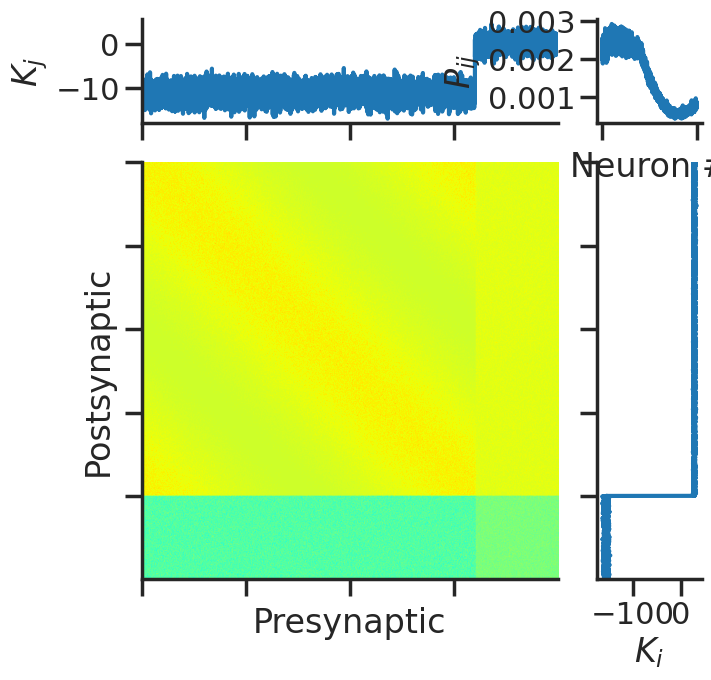

In [1]:
plot_con(sparse_matrix.to_dense().cpu().detach().numpy().T)

## Stimuli



### Imports



In [1]:
from src.stimuli import Stimuli

### ODR



(1000,)

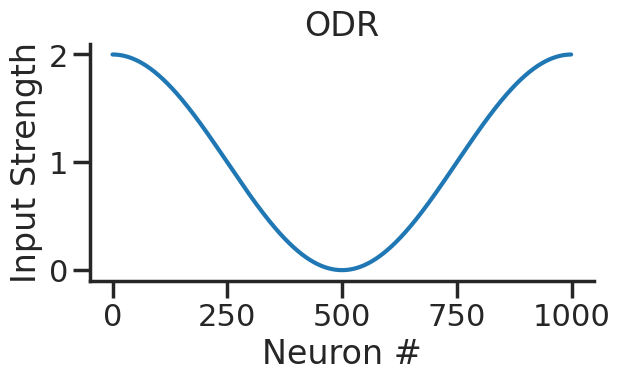

In [1]:
ff_input = Stimuli(task='odr', size=(1, 1000))(1, 1, 0).cpu().detach().numpy() 
print(ff_input.shape)
plt.plot(ff_input)
plt.xlabel('Neuron #')
plt.ylabel('Input Strength')
plt.title('ODR')
plt.show()

### Dual Task



(1000,)

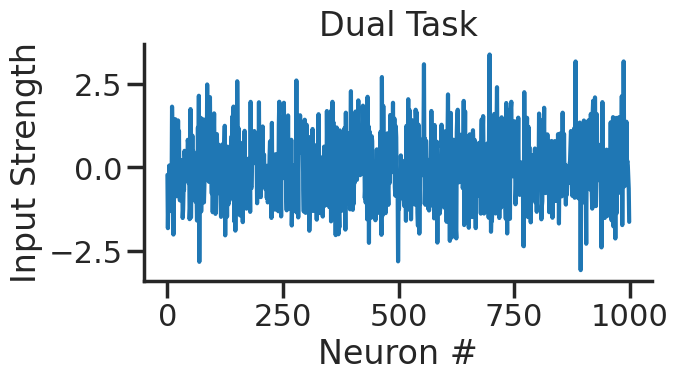

In [1]:
xi = torch.randn((1000), device='cuda')
ff_input = Stimuli(task='dual', size=(1, 1000))(1, 1, xi).cpu().detach().numpy()
print(ff_input.shape)
plt.plot(ff_input)
plt.xlabel('Neuron #')
plt.ylabel('Input Strength')
plt.title('Dual Task')
plt.show()

## FF Inputs



### ODR



In [1]:
REPO_ROOT = "/home/leon/models/NeuroTorch"
model = Network('config_EI.yml', 'test', REPO_ROOT, VERBOSE=1, DEVICE='cuda', TASK='odr',
                PROBA_TYPE=['cosine', '', '',''])

Na tensor([7500, 2500], device='cuda:0', dtype=torch.int32) Ka tensor([500., 500.], device='cuda:0') csumNa tensor([    0,  7500, 10000], device='cuda:0')
Jab [1.0, -1.5, 1, -1]
Ja0 [2.0, 1.0]
strong cosine probability
uniform probability
uniform probability
uniform probability

In [1]:
ff_input = model.init_ff_input().cpu().detach().numpy()
print(ff_input.shape)

task odr
torch.Size([7500])
(1, 660, 10000)

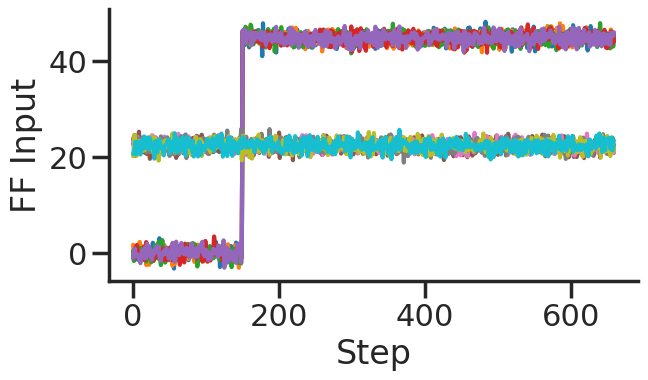

In [1]:
plt.plot(ff_input[0, :, :5])
plt.plot(ff_input[0, :, -5:])
plt.xlabel('Step')
plt.ylabel('FF Input')
plt.show()

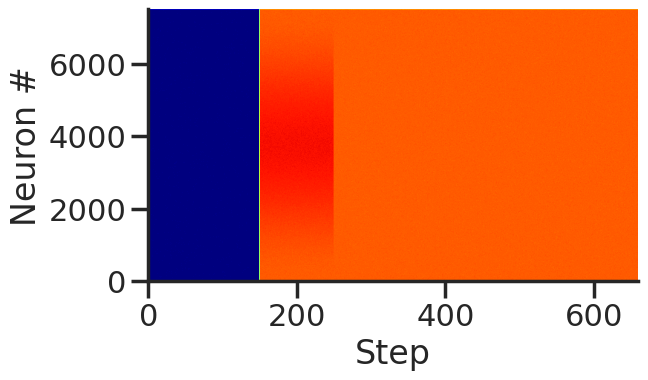

In [1]:
plt.imshow(ff_input[0].T, cmap='jet', vmin=0, vmax=55, aspect='auto')
plt.xlabel('Step')
plt.ylabel('Neuron #')
plt.ylim([0, 7500])
plt.show()

### Dual Task



In [1]:
REPO_ROOT = "/home/leon/models/NeuroTorch"
model = Network('config_EI.yml', 'test', REPO_ROOT, VERBOSE=1, DEVICE='cuda', TASK='dual',
                PROBA_TYPE=['lr', '', '',''])

Na tensor([7500, 2500], device='cuda:0', dtype=torch.int32) Ka tensor([500., 500.], device='cuda:0') csumNa tensor([    0,  7500, 10000], device='cuda:0')
Jab [1.0, -1.5, 1, -1]
Ja0 [2.0, 1.0]
low rank probability
uniform probability
uniform probability
uniform probability

In [1]:
ff_input = model.init_ff_input().cpu().detach().numpy()
print(ff_input.shape)

task dual
(1, 660, 10000)

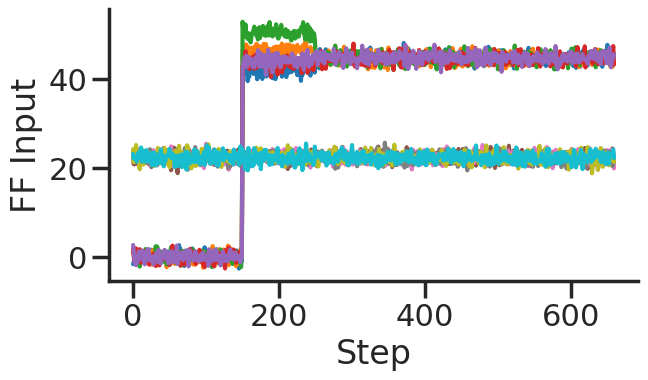

In [1]:
plt.plot(ff_input[0, :, :5])
plt.plot(ff_input[0, :, -5:])
plt.xlabel('Step')
plt.ylabel('FF Input')
plt.show()

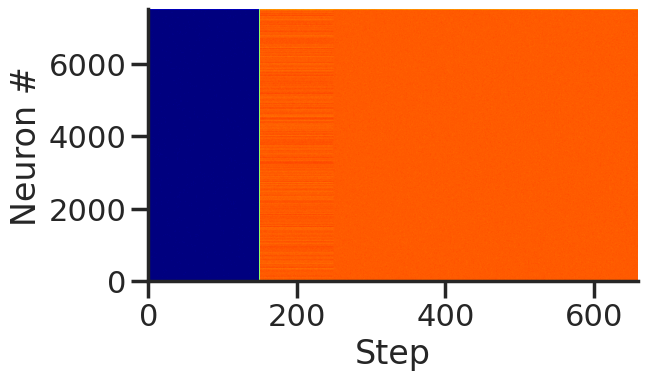

In [1]:
plt.imshow(ff_input[0].T, cmap='jet', vmin=0, vmax=55, aspect='auto')
plt.xlabel('Step')
plt.ylabel('Neuron #')
plt.ylim([0, 7500])
plt.show()

In [1]:
ksi = model.PHI0.cpu().detach().numpy()
print(ksi.shape)
idx = np.arange(0, len(ksi[0]))
theta = get_theta(ksi[0], ksi[1], GM=0, IF_NORM=1)
index_order = theta.argsort()
ff_ordered = ff_input[..., index_order]

(2, 7500)

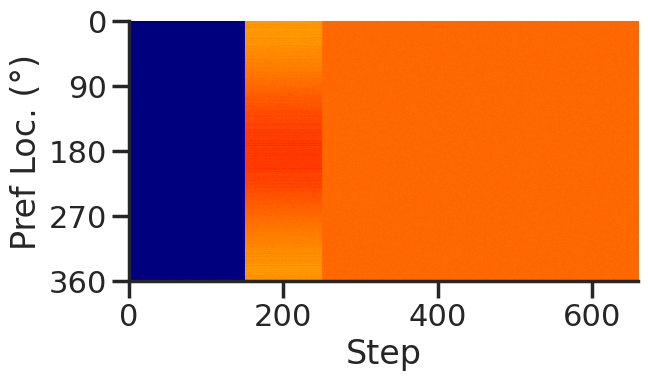

In [1]:
plt.imshow(ff_ordered[0].T, cmap='jet', vmin=0, aspect='auto')
plt.xlabel('Step')
plt.ylabel('Pref Loc. (°)')
plt.yticks(np.linspace(0, 7500, 5), np.linspace(0, 360, 5).astype(int))
# plt.ylim([0, 10])
plt.show()

## STP



### from class



In [1]:
from src.plasticity import Plasticity

In [1]:
stp = Plasticity(0.03, 0.65, 0.25, 0.01, (1,1000))

A_u_x = []
for i in range(300):
    rates = torch.randn((2, 1000), device='cuda')
    A_u_x.append( stp(rates)[0].cpu().detach().numpy())

A_u_x = np.array(A_u_x)

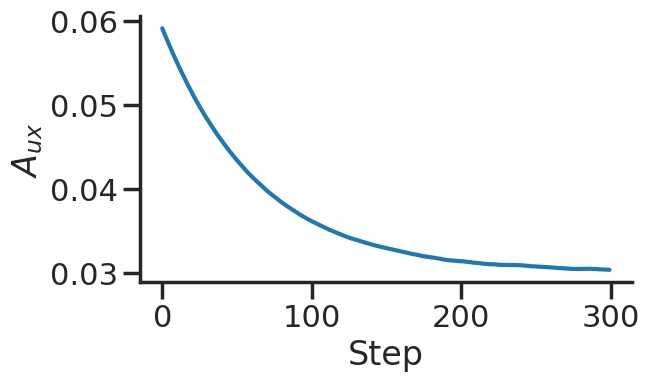

In [1]:
plt.plot(A_u_x.mean(1))
plt.xlabel('Step')
plt.ylabel('$A_{ux}$')
plt.show()

In [1]:
stp = Plasticity(0.03, 0.65, 0.25, 0.01, (1,1000))

A_u_x = []
for i in range(100):
    rates = i + torch.randn((2, 1000), device='cuda')
    A_u_x.append(stp(rates)[0].cpu().detach().numpy())

A_u_x = np.array(A_u_x)
print(A_u_x.shape)

(100, 1000)

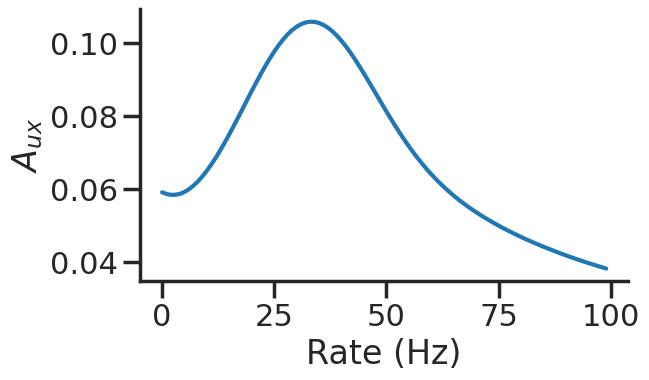

In [1]:
plt.plot(A_u_x.mean(1))
plt.xlabel('Rate (Hz)')
plt.ylabel('$A_{ux}$')
plt.show()

### from model



In [1]:
REPO_ROOT = "/home/leon/models/NeuroTorch"
model = Network('config_EI.yml', 'ord', REPO_ROOT, VERBOSE=1, DEVICE='cuda', IF_STP=1, LR_TRAIN=0, N_BATCH=1, DT=0.005, N_NEURON=10000, K=500)
rates = model(REC_LAST_ONLY=0).cpu().detach().numpy()

#+begin_example
  Na tensor([8000, 2000], device='cuda:0', dtype=torch.int32) Ka tensor([500., 500.], device='cuda:0') csumNa tensor([    0,  8000, 10000], device='cuda:0')
  Jab [1.0, -1.5, 1, -1]
  Ja0 [2.0, 1.0]
  generating ff input
  times (s) 0.0 rates (Hz) [4.38, 13.2]
  times (s) 0.01 rates (Hz) [4.41, 13.19]
  times (s) 0.02 rates (Hz) [4.41, 13.3]
  times (s) 0.03 rates (Hz) [4.41, 13.24]
  times (s) 0.04 rates (Hz) [4.4, 13.25]
  times (s) 0.05 rates (Hz) [4.39, 13.2]
  times (s) 0.05 rates (Hz) [4.39, 13.26]
  times (s) 0.06 rates (Hz) [4.41, 13.23]
  times (s) 0.07 rates (Hz) [4.41, 13.29]
  times (s) 0.08 rates (Hz) [4.4, 13.27]
  times (s) 0.09 rates (Hz) [4.37, 13.2]
  times (s) 0.1 rates (Hz) [4.37, 13.23]
  times (s) 0.11 rates (Hz) [4.4, 13.29]
  times (s) 0.12 rates (Hz) [4.39, 13.29]
  times (s) 0.13 rates (Hz) [4.33, 13.15]
  times (s) 0.14 rates (Hz) [4.37, 13.26]
  times (s) 0.15 rates (Hz) [4.38, 13.19]
  times (s) 0.16 rates (Hz) [4.39, 13.21]
  times (s) 0.16

(1, 551, 8000)

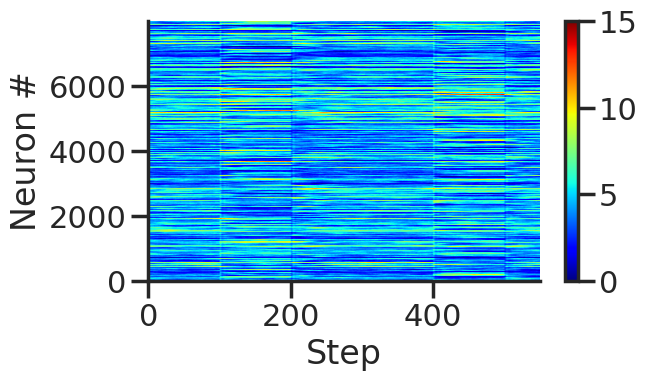

In [1]:
print(rates.shape)
r_max = 15 # * np.max(rates[-1, :15000])
plt.imshow(rates[0].T, aspect='auto', cmap='jet', vmin=0, vmax=r_max, origin='lower')
plt.ylabel('Neuron #')
plt.xlabel('Step')
plt.colorbar()
plt.show()

## Single Trial



### Model



In [1]:
REPO_ROOT = "/home/leon/models/NeuroTorch"
model = Network('config_2pop.yml', 'test', REPO_ROOT, VERBOSE=1, DEVICE='cuda', TASK='None')

Na tensor([8000, 2000], device='cuda:0', dtype=torch.int32) Ka tensor([500., 500.], device='cuda:0') csumNa tensor([    0,  8000, 10000], device='cuda:0')
Jab [1.0, -1.5, 1, -1]
Ja0 [2.0, 1.0]

### Connectivity



(10000, 10000)

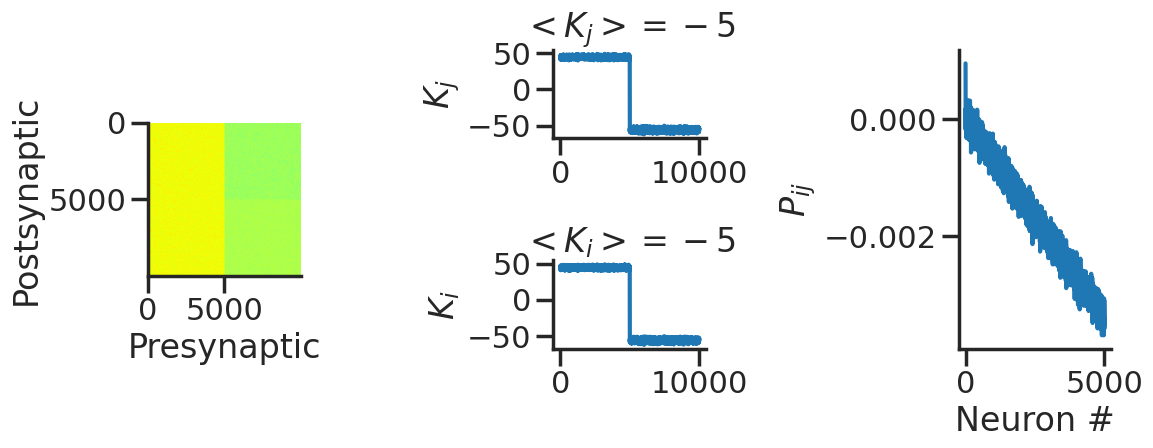

In [1]:
Cij = model.Wab.cpu().detach().numpy() 
print(Cij.shape)

plt.figure(figsize=(12, 5))  # Set the figure size (width, height) in inches

ax1 = plt.subplot2grid((2, 3), (0, 0), rowspan=2)
im = ax1.imshow(Cij, cmap='jet', aspect=1)
ax1.set_xlabel("Presynaptic")
ax1.set_ylabel("Postsynaptic")

# Second column, first row
ax2 = plt.subplot2grid((2, 3), (0, 1))
Kj = np.sum(Cij, axis=0)  # sum over pres
ax2.set_title('$<K_j>= %d$' % np.mean(Kj))
ax2.plot(Kj)
# ax2.set_xticklabels([])
ax2.set_ylabel("$K_j$")

# # Second column, second row
ax3 = plt.subplot2grid((2, 3), (1, 1))
Ki = np.sum(Cij, axis=1)  # sum over pres
ax3.set_title('$<K_i>= %d$' % np.mean(Ki))
ax3.plot(Kj)
ax3.set_ylabel("$K_i$")

ax4 = plt.subplot2grid((2, 3), (0, 2), rowspan=2)
diags = []
for i in range(int(Cij.shape[0] / 2)):
    diags.append(np.trace(Cij, offset=i) / Cij.shape[0])
diags = np.array(diags)
ax4.plot(diags)
ax4.set_xlabel("Neuron #")
ax4.set_ylabel("$P_{ij}$")

plt.tight_layout()
plt.show()

### FF Inputs



(1, 660, 10000)

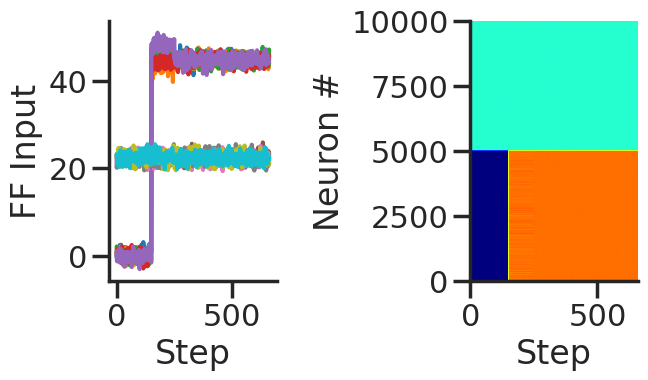

In [1]:
ff_input = model.ff_input.cpu().detach().numpy()
print(ff_input.shape)

fig, ax = plt.subplots(1, 2)

ax[0].plot(ff_input[0, :, :5])
ax[0].plot(ff_input[0, :, -5:])
ax[0].set_xlabel('Step')
ax[0].set_ylabel('FF Input')

ax[1].imshow(ff_input[0].T, cmap='jet', vmin=0, aspect='auto')
ax[1].set_xlabel('Step')
ax[1].set_ylabel('Neuron #')
ax[1].set_ylim([0, 10000])
plt.show()

### Dynamics



In [1]:
rates = model.forward(REC_LAST_ONLY=0)[0].cpu().detach().numpy()
print(rates.shape)

generating ff input
times (s) 0.0 rates (Hz) [8.9, 13.43]
times (s) 0.6 rates (Hz) [8.28, 12.98]
times (s) 1.2 rates (Hz) [8.02, 12.69]
times (s) 1.8 rates (Hz) [7.81, 12.54]
Elapsed (with compilation) = 0.5204478511586785s
(4, 8000)

(4, 8000)

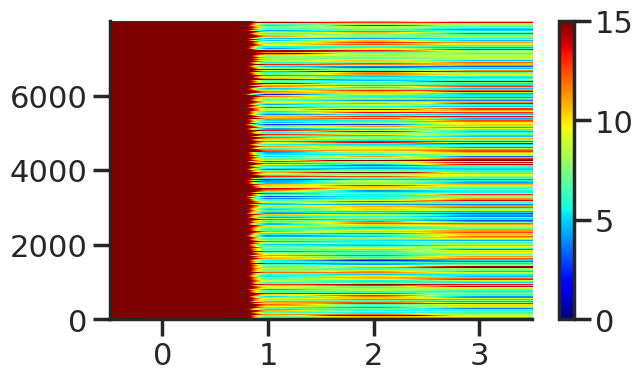

In [1]:
r_max = 15 
plt.imshow(rates.T, aspect='auto', cmap='jet', vmin=0, vmax=r_max, origin='lower')
plt.colorbar()
plt.show()

#### dual



In [1]:
ksi = model.PHI0.cpu().detach().numpy()
idx = np.arange(0, len(ksi[0]))
theta = get_theta(ksi[0], ksi[1], GM=0, IF_NORM=1)
index_order = theta.argsort()
rates_ordered = rates[:, index_order]

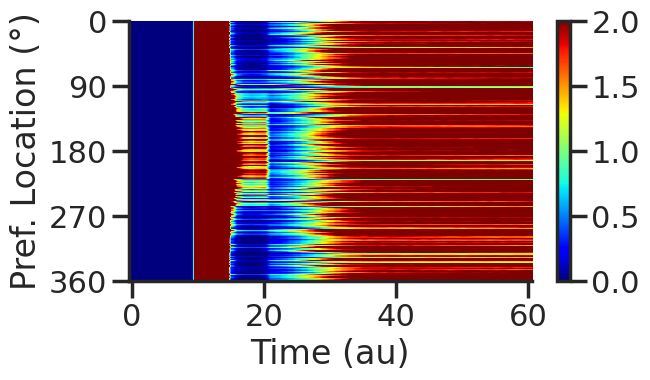

In [1]:
plt.imshow(rates_ordered.T, aspect='auto', cmap='jet', vmin=0, vmax=2)
plt.ylabel('Pref. Location (°)')
plt.xlabel('Time (au)')
plt.yticks(np.linspace(0, idx.shape[0], 5), np.linspace(0, 360, 5).astype(int))
plt.colorbar()
plt.show()

In [1]:
m0, m1, phi = decode_bump(rates, axis=-1)

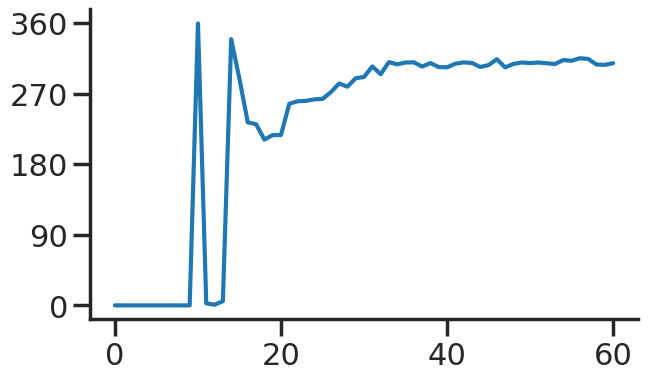

In [1]:
plt.plot((phi * 180 / np.pi))
plt.yticks(np.linspace(0, 360, 5).astype(int), np.linspace(0, 360, 5).astype(int))  
plt.show()

## Balance



In [1]:
REPO_ROOT = "/home/leon/models/NeuroTorch"
K_list = [500, 1000, 1500, 2000, 2500, 3000]
rates_list = []

for K in K_list:
    model = Network('config_2pop.yml', 'balance', REPO_ROOT, VERBOSE=0, DEVICE='cuda', K=K)
    rates = model.forward()
    rates_list.append(rates[0].cpu().detach().numpy())

c548e102-bffc-4bcb-b865-52c9c61c257c

(6, 7500)

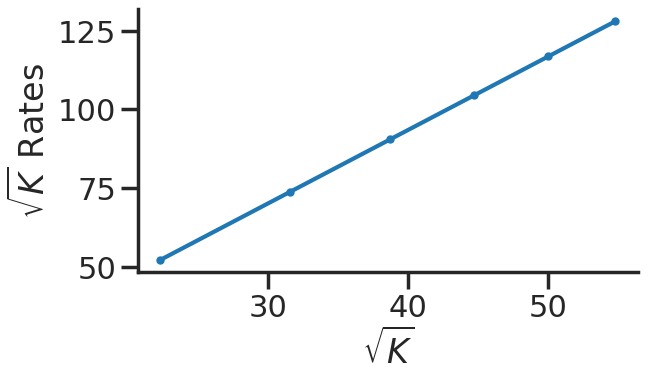

In [1]:
rates = np.array(rates_list)
print(rates.shape)

# rates = rates[:, 0, :30000]
plt.plot(np.sqrt(K_list), np.mean(rates) * np.sqrt(K_list), '-o')
plt.xlabel('$\sqrt{K}$')
plt.ylabel('$\sqrt{K}$ Rates')
plt.show()